# Light Curves

Time-domain surveys systematically scan the sky and provide light curves for millions of sources. A light curve contains multiple photometric observations at different times and provides the evolution of brigthness over time. A typical light curve will contain:
- <b>Time </b> <br>
Time is traditionally expressed in Modified Julian Dates (MJD).
- <b>Brightness/Magnitude </b> <br>
In optical and UV light curves the brightness is traditionally expressed in magnitudes $m_\nu$, which is related to the flux $F_\nu$ of the source. $$ m_{\nu} = -2.5 \log_{10} \left(\frac{F_\nu}{F_{\nu,0}}\right)  $$
- <b>Photometric error </b> <br> 
The measurement error of each observation, also typically expressed in magnitudes.
- <b> Other </b> <br>
Quality flags about each observation, statistics related to data reduction, etc.

### Extract light curves from time domain surveys

There are multiple ongoing and past time-domain surveys with public data
- Catalina Real-time Transient Survey [CRTS database](http://nunuku.caltech.edu/cgi-bin/getmulticonedb_release2.cgi)
- Zwicky Transient Facility  [ZTF database](https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?projshort=ZTF&mission=irsa)
- All-Sky Automated Survey for Supernovae [ASAS-SN database](https://asas-sn.osu.edu)
- Palomar Transient Factory (2008-2012)  [PTF database](https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?submit=Select&projshort=PTF)

You need to specify the coordinates of interest (Ra, Dec) and a search radius OR you can upload a txt file with the coordinates of multiple sources OR you can run an SQL query.

### To Do

Download and plot the light curves of the binary candidate PG1302-102 [Graham et al. 2015](https://ui.adsabs.harvard.edu/abs/2015Natur.518...74G/abstract) <br>
Coordinates <b>Ra</b> 13:05:33.0150535680 <b>Dec</b> -10:33:19.430383680

In [4]:
#import data
import numpy as np
data_pub = np.loadtxt('PG1302_Nature_Fig.dat')
mjd_pub = data_pub[:,0]
mag_pub = data_pub[:,1]
magErr_pub = data_pub[:,2]

data_asassn = np.loadtxt('ASAS_SN_Binned.txt')
mjd_asassn = data_asassn[:,0]
mag_asassn = data_asassn[:,1]
magErr_asassn = data_asassn[:,2]

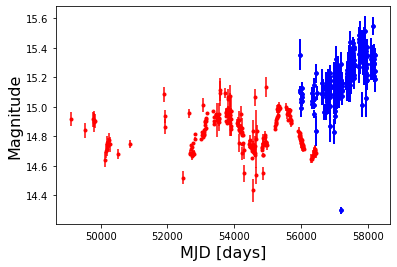

In [13]:
#plot light curves
import matplotlib.pyplot as plt
plt.errorbar(mjd_pub, mag_pub, magErr_pub, fmt='.', c='r')
plt.errorbar(mjd_asassn, mag_asassn, magErr_asassn, fmt='.', c='b')
plt.xlabel('MJD [days]',fontsize=16)
plt.ylabel('Magnitude',fontsize=16)
plt.show()

Light curves from different surveys need to be callibrated properly!!! This takes into account the filter in which observations were made, the photometric system in which they were callibrated and the color of the source.

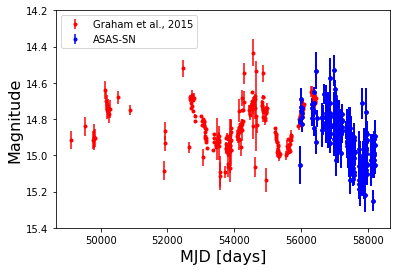

In [93]:
#plot light curves with "correct" offset
import matplotlib.pyplot as plt
plt.errorbar(mjd_pub, mag_pub, magErr_pub, fmt='.', c='r')
plt.errorbar(mjd_asassn, mag_asassn-0.3, magErr_asassn, fmt='.', c='b')
plt.xlabel('MJD [days]',fontsize=16)
plt.ylabel('Magnitude',fontsize=16)
plt.legend(['Graham et al., 2015','ASAS-SN'])
plt.ylim(15.4, 14.2)
plt.show()

# Search for periodicity--Lomb Scargle Periodogram

In general, a periodogram is an estimate of the spectral density of the time series. In evenly sampled data, (e.g., LIGO data) a discrete Fourier transform is an efficient method to calculate the spectral density. 

Light curves from ground based telescopes inevitably have gaps for multiple reasons:
- The source is behind the Sun
- The source is below the horizon
- The weather/observing conditions were bad and observations were not made
- Instrument failure
- Other <br>
Therefore, traditional Fourier-based methods which require continuous (evenly sampled) observations don't work.

The most popular method to detect a periodic signal in unevenly sampled data is the Lomb-Scargle periodogram.<br> Relevant referencees:
- [Lomb+1976](https://ui.adsabs.harvard.edu/abs/1976Ap%26SS..39..447L/abstract)
- [Scargle+1982](https://ui.adsabs.harvard.edu/abs/1982ApJ...263..835S/abstract)
- [VanderPlas+2018](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V/abstract)
 

### Lomb-Scargle Periodogram for evenly sample data

        Use astropy.stats.LombScargle instead. [warnings]


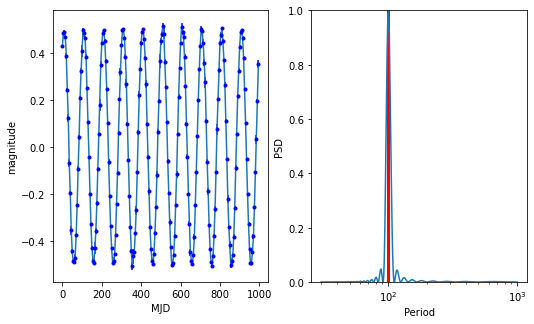

In [284]:
#Generate an evenly sampled sinusoid
Tmax = 1000
dt = 5
Period = 100
A = 0.5
avg_phot_err=0.01

tt = np.arange(0,Tmax,dt)
yy = A*np.sin(2*np.pi/Period*tt+np.pi/3) 
yy_err = np.random.normal(0,avg_phot_err,len(tt))
yy = yy + yy_err

plt.subplot(1,2,1)
plt.plot(tt,yy)
plt.errorbar(tt,yy,yy_err, fmt='.', c='b')
plt.xlabel('MJD')
plt.ylabel('magnitude')
# plt.show()


#Periodogram
from astroML.time_series import lomb_scargle

#Define frequencies

omega_min = 2*np.pi/Tmax         #The minimum frequency is determined by the lenght (baseline) of the light curve.
#omega_max = omega_max/Ncycles   #But we may require a minimum number of cycles Ncycles to be observed within the baseline
omega_max = 1*np.pi/np.mean(np.diff(tt))        #The minimum frequency can be set by the average sampling rate (i.e. a pseudo-Nyquist frequency for unevenly sampled data) 
Tmin = 30
omega_max = 2*np.pi/Tmin         #But we can also set it arbitrarily at the minimum period of interest, which for quasars should be a few months.


omega = np.linspace(omega_min, omega_max, 1000)
P_LS = lomb_scargle(tt, yy, avg_phot_err, omega, generalized=True)
plt.subplot(1,2,2)
plt.plot(2*np.pi/omega,P_LS)
plt.vlines(Period,0,1,colors='r',linewidth=3)
plt.ylim([0,1])
plt.xlabel('Period')
plt.ylabel('PSD')
plt.xscale('log')
plt.show()

### To Do

Vary the parameters of the injected sinusoid (period, amplitude, photometric noise) and/or the sampling pattern (baseline, frequency of observations) and see how the peak of the periodogram changes.

### Lomb-Scargle Periodogram for unevenly sample data

        Use astropy.stats.LombScargle instead. [warnings]


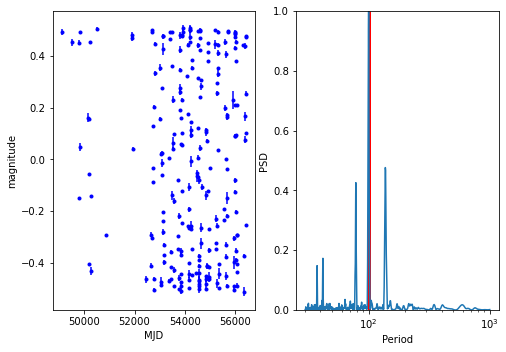

In [290]:
#Sample a sinusoid at the observed times of PG1302 from above
Period = 100
A = 0.5
avg_phot_err=0.01

tt = mjd_pub
yy = A*np.sin(2*np.pi/Period*tt+np.pi/3) 
yy_err = np.random.normal(0,avg_phot_err,len(tt))
yy = yy + yy_err

plt.subplot(1,2,1)
# plt.rcParams["figure.figsize"] = (8,5.5)
# plt.plot(tt,yy)
plt.errorbar(tt,yy,yy_err, fmt='.', c='b')
plt.xlabel('MJD')
plt.ylabel('magnitude')
# plt.show()


#Periodogram
from astroML.time_series import lomb_scargle

#Define frequencies

omega_min = 2*np.pi/Tmax         #The minimum frequency is determined by the lenght (baseline) of the light curve.
#omega_max = omega_max/Ncycles   #But we may require a minimum number of cycles Ncycles to be observed within the baseline
# omega_max = 1*np.pi/np.mean(np.diff(tt))        #The minimum frequency can be set by the average sampling rate (i.e. a pseudo-Nyquist frequency for unevenly sampled data) 
Tmin = 30
omega_max = 2*np.pi/Tmin         #But we can also set it arbitrarily at the minimum period of interest, which for quasars should be a few months.


omega = np.linspace(omega_min, omega_max, 1000)
P_LS = lomb_scargle(tt, yy, avg_phot_err, omega, generalized=True)
plt.subplot(1,2,2)
plt.plot(2*np.pi/omega,P_LS)
plt.vlines(Period,0,1,colors='r',linewidth=3)
plt.ylim([0,1])
plt.xscale('log')
plt.xlabel('Period')
plt.ylabel('PSD')
plt.show()

### To Do

Simulate a noiseless sinusoid with the properties of PG1302 at the observed pattern of PG1302 and explore whether additional sinusoidal components could be detected (see also [Charisi+2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.454L..21C/abstract)). This is important because identifying multiple periodic components with a characteristic frequency pattern can serve as an additional signature for the binary nature of the candidate and increase its credibility.

### Aliasing

Power is falsely transfered to other frequencies (primarily due to "slow" sampling rate)

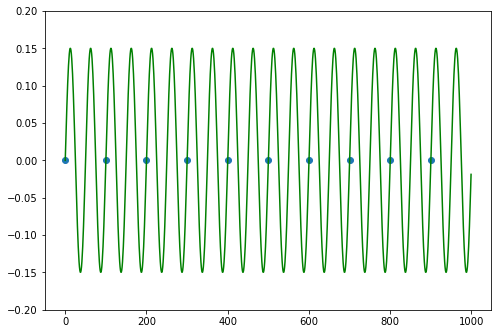

In [288]:
tt=np.arange(0,1000,100)
Period = 200
A = 0.15
yy = A*np.sin(2*np.pi/Period*tt) 

tt2=np.arange(0,1000,1)
yy2 = A*np.sin(2*np.pi/Period*tt2) 
yy3 = A*np.sin(2*np.pi/(Period/2)*tt2) 
yy4 = A*np.sin(2*np.pi/(Period/4)*tt2) 


# plt.plot(tt2,yy2,c='r')
# plt.plot(tt2,yy3,c='b')
plt.plot(tt2,yy4,c='g')

plt.scatter(tt,yy)
plt.ylim([-0.2,0.2])
plt.show()

### False Alarm Probability

Once we detect a peak, how do we know if it is statistically significant or just noise? What is the probability of this peak arising by chance?
- Bootstraping/Scrambling

# Quasar Variability

Quasars show stochastic variability, best described by a Damped Random Walk (DRW) model. The power spectral distribution is flat for low frequencies (white noise), and decreases with increasing frequency for higher frequencies (red noise).
$$ PSD(f)=\frac{4 \sigma^2 \tau}{1+(2\pi \tau f)^2} $$

Relevant references:
- [Kelly+2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract)
- [MacLeod+2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...721.1014M/abstract)
- [Kozlowski+2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...708..927K/abstract)



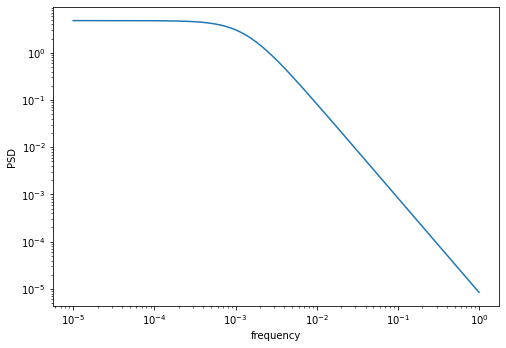

In [294]:
#plot PSD of DRW
f=np.logspace(-5,0,1000)

sigma=0.1
tau=120
PSD=4*sigma**2*tau/(1+(2*np.pi*tau*f)**2)

plt.plot(f,PSD)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PSD')
plt.xlabel('frequency')
plt.show()

In [270]:
def generate_DRW_timeseries(N, dt, sigma, tau, generate_complex=False, random_state=None):
    from astroML.utils import check_random_state
    """Generate a power-law light curve
        This uses the method from Timmer & Koenig [1]_
           
        Parameters
           
        ----------
           
        N : integer
           
        Number of equal-spaced time steps to generate
           
        dt : float
           
        Spacing between time-steps
           
        generate_complex : boolean (optional)
           
        if True, generate a complex time series rather than a real time series
           
        random_state : None, int, or np.random.RandomState instance (optional)
           
        random seed or random number generator
           
           
           
        Returns
           
        -------
           
        x : ndarray
           
        the length-N
           
           
           
        References
           
        ----------
           
        .. [1] Timmer, J. & Koenig, M. On Generating Power Law Noise. A&A 300:707
           
    """


    random_state = check_random_state(random_state)
    
    
    dt = float(dt)
    
    N = int(N)
    
    
    
    
    Npos = int(N / 2)
    
    Nneg = int((N - 1) / 2)
    
    domega = (2 * np.pi / dt / N)
    
    df = (1 / dt / N)
    
    
    
    if generate_complex:
        
        omega = domega * np.fft.ifftshift(np.arange(N) - int(N / 2))

    else:
        
        omega = domega * np.arange(Npos + 1)

    if generate_complex:
    
        freq = df * np.fft.ifftshift(np.arange(N) - int(N / 2))
    
    else:
        
        freq = df * np.arange(Npos + 1)


    x_fft = np.zeros(len(omega), dtype=complex)

    x_fft.real[1:] = random_state.normal(0, 1, len(omega) - 1)

    x_fft.imag[1:] = random_state.normal(0, 1, len(omega) - 1)

 ###Specify the form of PSD^{1/2}--BE CONSISTENT with the notation! Different definitions of sigma and tau in several papers
    x_fft[1:] *=2*sigma*np.sqrt(tau/(1+omega[1:]**2*tau**2))

    x_fft[1:] *= (1. / np.sqrt(2))


    if (not generate_complex) and (N % 2 == 0):
    
        x_fft.imag[-1] = 0

    if generate_complex:
        
        x = np.fft.ifft(x_fft)

    else:
        
        x = np.fft.irfft(x_fft, N)




    return x


        Use sklearn.utils.check_random_state instead. [warnings]


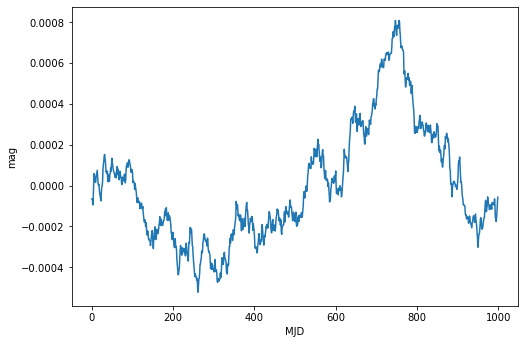

In [299]:
dt=1
N=1000
sigma=0.01
tau=500
mag=generate_DRW_timeseries(N, dt, sigma, tau, generate_complex=False, random_state=None)

tt=np.arange(0,N*dt,dt)
plt.plot(tt,mag)
plt.xlabel('MJD')
plt.ylabel('mag')
plt.show()

### To Do

Explore a variety of DRW parameters.

Use the DRW parameters for PG1302 (see Table 1 in [Xin+2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.496.1683X/abstract) for a summary). Simulate light curves with the observed properties of PG1302 and calculate the periodograms. Compare with the periodogram of the observed light curve to estimate the false alarm probability of the periodicity. 

### Trial Factors
However, if we have looked at a large sampe of sources, the look-elsewhere effect becomes important and needs to be taken into account in the calculation of the false alarm probability. In addition, in the case of red noise, we will be looking to assess the significance of a peak at a certain frequency (not at any frequency like in white noise) and thus the number of frequencies searches introduces more trial factors.
[Barth+Stern 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...859...10B/abstract)

### To Do

The zip file contains 100 quasar light curves from CRTS to put your periodicity search skills to work!!!